In [1]:

!pip install dm-reverb[tensorflow]
!pip install rlds[tensorflow]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.6 MB/s eta 0:00:00


In [2]:
# @title Transformation definitions


from typing import Any, Dict, Union, NamedTuple

import numpy as np
import tensorflow_datasets as tfds
import rlds
import reverb
from rlds import transformations
import tensorflow_datasets as tfds
import tree
import math

from tqdm import tqdm

import abc
import dataclasses
from typing import Dict, Optional

from rlds import rlds_types
import tensorflow as tf
from PIL import Image
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

def _features_to_tensor_spec(
    feature: tfds.features.FeatureConnector
) -> tf.TensorSpec:
  """Converts a tfds Feature into a TensorSpec."""

  def _get_feature_spec(nested_feature: tfds.features.FeatureConnector):
    if isinstance(nested_feature, tf.DType):
      return tf.TensorSpec(shape=(), dtype=nested_feature)
    else:
      return nested_feature.get_tensor_spec()

  # FeaturesDict can sometimes be a plain dictionary, so we use tf.nest to
  # make sure we deal with the nested structure.
  return tf.nest.map_structure(_get_feature_spec, feature)


def _encoded_feature(feature: Optional[tfds.features.FeatureConnector],
                     image_encoding: Optional[str],
                     tensor_encoding: Optional[tfds.features.Encoding]):
  """Adds encoding to Images and/or Tensors."""
  def _apply_encoding(feature: tfds.features.FeatureConnector,
                      image_encoding: Optional[str],
                      tensor_encoding: Optional[tfds.features.Encoding]):
    if image_encoding and isinstance(feature, tfds.features.Image):
      return tfds.features.Image(
          shape=feature.shape,
          dtype=feature.dtype,
          use_colormap=feature.use_colormap,
          encoding_format=image_encoding)
    if tensor_encoding and isinstance(
        feature, tfds.features.Tensor) and feature.dtype != tf.string:
      return tfds.features.Tensor(
          shape=feature.shape, dtype=feature.dtype, encoding=tensor_encoding)
    return feature

  if not feature:
    return None
  return tf.nest.map_structure(
      lambda x: _apply_encoding(x, image_encoding, tensor_encoding), feature)


@dataclasses.dataclass
class RLDSSpec(metaclass=abc.ABCMeta):
  """Specification of an RLDS Dataset.

  It is used to hold a spec that can be converted into a TFDS DatasetInfo or
  a `tf.data.Dataset` spec.
  """
  observation_info: Optional[tfds.features.FeatureConnector] = None
  action_info: Optional[tfds.features.FeatureConnector] = None
  reward_info: Optional[tfds.features.FeatureConnector] = None
  discount_info: Optional[tfds.features.FeatureConnector] = None
  step_metadata_info: Optional[tfds.features.FeaturesDict] = None
  episode_metadata_info: Optional[tfds.features.FeaturesDict] = None

  def step_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    step = {}
    if self.observation_info:
      step[rlds_types.OBSERVATION] = _features_to_tensor_spec(
          self.observation_info)
    if self.action_info:
      step[rlds_types.ACTION] = _features_to_tensor_spec(
          self.action_info)
    if self.discount_info:
      step[rlds_types.DISCOUNT] = _features_to_tensor_spec(
          self.discount_info)
    if self.reward_info:
      step[rlds_types.REWARD] = _features_to_tensor_spec(
          self.reward_info)
    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step[k] = _features_to_tensor_spec(v)

    step[rlds_types.IS_FIRST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_LAST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_TERMINAL] = tf.TensorSpec(shape=(), dtype=bool)
    return step

  def episode_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    episode = {}
    episode[rlds_types.STEPS] = tf.data.DatasetSpec(
        element_spec=self.step_tensor_spec())
    if self.episode_metadata_info:
      for k, v in self.episode_metadata_info.items():
        episode[k] = _features_to_tensor_spec(v)
    return episode

  def to_dataset_config(
      self,
      name: str,
      image_encoding: Optional[str] = None,
      tensor_encoding: Optional[tfds.features.Encoding] = None,
      citation: Optional[str] = None,
      homepage: Optional[str] = None,
      description: Optional[str] = None,
      overall_description: Optional[str] = None,
  ) -> tfds.rlds.rlds_base.DatasetConfig:
    """Obtains the DatasetConfig for TFDS from the Spec."""
    return tfds.rlds.rlds_base.DatasetConfig(
        name=name,
        description=description,
        overall_description=overall_description,
        homepage=homepage,
        citation=citation,
        observation_info=_encoded_feature(self.observation_info, image_encoding,
                                          tensor_encoding),
        action_info=_encoded_feature(self.action_info, image_encoding,
                                     tensor_encoding),
        reward_info=_encoded_feature(self.reward_info, image_encoding,
                                     tensor_encoding),
        discount_info=_encoded_feature(self.discount_info, image_encoding,
                                       tensor_encoding),
        step_metadata_info=_encoded_feature(self.step_metadata_info,
                                            image_encoding, tensor_encoding),
        episode_metadata_info=_encoded_feature(self.episode_metadata_info,
                                               image_encoding, tensor_encoding))

  def to_features_dict(self):
    """Returns a TFDS FeaturesDict representing the dataset config."""
    step_config = {
        rlds_types.IS_FIRST: tf.bool,
        rlds_types.IS_LAST: tf.bool,
        rlds_types.IS_TERMINAL: tf.bool,
    }

    if self.observation_info:
      step_config[rlds_types.OBSERVATION] = self.observation_info
    if self.action_info:
      step_config[rlds_types.ACTION] = self.action_info
    if self.discount_info:
      step_config[rlds_types.DISCOUNT] = self.discount_info
    if self.reward_info:
      step_config[rlds_types.REWARD] = self.reward_info

    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step_config[k] = v

    if self.episode_metadata_info:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
          **self.episode_metadata_info,
      })
    else:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
      })

RLDS_SPEC = RLDSSpec
TENSOR_SPEC = Union[tf.TensorSpec, dict[str, tf.TensorSpec]]


@dataclasses.dataclass
class TrajectoryTransform(metaclass=abc.ABCMeta):
  """Specification the TrajectoryTransform applied to a dataset of episodes.

  A TrajectoryTransform is a set of rules transforming a dataset
  of RLDS episodes to a dataset of trajectories.
  This involves three distinct stages:
  - An optional `episode_to_steps_map_fn(episode)` is called at the episode
    level, and can be used to select or modify steps.
    - Augmentation: an `episode_key` could be propagated to `steps` for
      debugging.
    - Selection: Particular steps can be selected.
    - Stripping: Features can be removed from steps. Prefer using `step_map_fn`.
  - An optional `step_map_fn` is called at the flattened steps dataset for each
    step, and can be used to featurize a step, e.g. add/remove features, or
    augument images
  - A `pattern` leverages DM patterns to set a rule of slicing an episode to a
    dataset of overlapping trajectories.

  Importantly, each TrajectoryTransform must define a `expected_tensor_spec`
  which specifies a nested TensorSpec of the resulting dataset. This is what
  this TrajectoryTransform will produce, and can be used as an interface with
  a neural network.
  """
  episode_dataset_spec: RLDS_SPEC
  episode_to_steps_fn_dataset_spec: RLDS_SPEC
  steps_dataset_spec: Any
  pattern: reverb.structured_writer.Pattern
  episode_to_steps_map_fn: Any
  expected_tensor_spec: TENSOR_SPEC
  step_map_fn: Optional[Any] = None

  def get_for_cached_trajectory_transform(self):
    """Creates a copy of this traj transform to use with caching.

    The returned TrajectoryTransfrom copy will be initialized with the default
    version of the `episode_to_steps_map_fn`, because the effect of that
    function has already been materialized in the cached copy of the dataset.
    Returns:
      trajectory_transform: A copy of the TrajectoryTransform with overridden
        `episode_to_steps_map_fn`.
    """
    traj_copy = dataclasses.replace(self)
    traj_copy.episode_dataset_spec = traj_copy.episode_to_steps_fn_dataset_spec
    traj_copy.episode_to_steps_map_fn = lambda e: e[rlds_types.STEPS]
    return traj_copy

  def transform_episodic_rlds_dataset(self, episodes_dataset: tf.data.Dataset):
    """Applies this TrajectoryTransform to the dataset of episodes."""

    # Convert the dataset of episodes to the dataset of steps.
    steps_dataset = episodes_dataset.map(
        self.episode_to_steps_map_fn, num_parallel_calls=tf.data.AUTOTUNE
    ).flat_map(lambda x: x)

    return self._create_pattern_dataset(steps_dataset)

  def transform_steps_rlds_dataset(
      self, steps_dataset: tf.data.Dataset
  ) -> tf.data.Dataset:
    """Applies this TrajectoryTransform to the dataset of episode steps."""

    return self._create_pattern_dataset(steps_dataset)

  def create_test_dataset(
      self,
  ) -> tf.data.Dataset:
    """Creates a test dataset of trajectories.

    It is guaranteed that the structure of this dataset will be the same as
    when flowing real data. Hence this is a useful construct for tests or
    initialization of JAX models.
    Returns:
      dataset: A test dataset made of zeros structurally identical to the
        target dataset of trajectories.
    """
    zeros = transformations.zeros_from_spec(self.expected_tensor_spec)

    return tf.data.Dataset.from_tensors(zeros)

  def _create_pattern_dataset(
      self, steps_dataset: tf.data.Dataset) -> tf.data.Dataset:
    """Create PatternDataset from the `steps_dataset`."""
    config = create_structured_writer_config('temp', self.pattern)

    # Further transform each step if the `step_map_fn` is provided.
    if self.step_map_fn:
      steps_dataset = steps_dataset.map(self.step_map_fn)
    pattern_dataset = reverb.PatternDataset(
        input_dataset=steps_dataset,
        configs=[config],
        respect_episode_boundaries=True,
        is_end_of_episode=lambda x: x[rlds_types.IS_LAST])
    return pattern_dataset


class TrajectoryTransformBuilder(object):
  """Facilitates creation of the `TrajectoryTransform`."""

  def __init__(self,
               dataset_spec: RLDS_SPEC,
               episode_to_steps_map_fn=lambda e: e[rlds_types.STEPS],
               step_map_fn=None,
               pattern_fn=None,
               expected_tensor_spec=None):
    self._rds_dataset_spec = dataset_spec
    self._steps_spec = None
    self._episode_to_steps_map_fn = episode_to_steps_map_fn
    self._step_map_fn = step_map_fn
    self._pattern_fn = pattern_fn
    self._expected_tensor_spec = expected_tensor_spec

  def build(self,
            validate_expected_tensor_spec: bool = True) -> TrajectoryTransform:
    """Creates `TrajectoryTransform` from a `TrajectoryTransformBuilder`."""

    if validate_expected_tensor_spec and self._expected_tensor_spec is None:
      raise ValueError('`expected_tensor_spec` must be set.')

    episode_ds = zero_episode_dataset_from_spec(self._rds_dataset_spec)

    steps_ds = episode_ds.flat_map(self._episode_to_steps_map_fn)

    episode_to_steps_fn_dataset_spec = self._rds_dataset_spec

    if self._step_map_fn is not None:
      steps_ds = steps_ds.map(self._step_map_fn)

    zeros_spec = transformations.zeros_from_spec(steps_ds.element_spec)  # pytype: disable=wrong-arg-types

    ref_step = reverb.structured_writer.create_reference_step(zeros_spec)

    pattern = self._pattern_fn(ref_step)

    steps_ds_spec = steps_ds.element_spec

    target_tensor_structure = create_reverb_table_signature(
        'temp_table', steps_ds_spec, pattern)

    if (validate_expected_tensor_spec and
        self._expected_tensor_spec != target_tensor_structure):
      raise RuntimeError(
          'The tensor spec of the TrajectoryTransform doesn\'t '
          'match the expected spec.\n'
          'Expected:\n%s\nActual:\n%s\n' %
          (str(self._expected_tensor_spec).replace('TensorSpec',
                                                   'tf.TensorSpec'),
           str(target_tensor_structure).replace('TensorSpec', 'tf.TensorSpec')))

    return TrajectoryTransform(
        episode_dataset_spec=self._rds_dataset_spec,
        episode_to_steps_fn_dataset_spec=episode_to_steps_fn_dataset_spec,
        steps_dataset_spec=steps_ds_spec,
        pattern=pattern,
        episode_to_steps_map_fn=self._episode_to_steps_map_fn,
        step_map_fn=self._step_map_fn,
        expected_tensor_spec=target_tensor_structure)

def zero_episode_dataset_from_spec(rlds_spec: RLDS_SPEC):
  """Creates a zero valued dataset of episodes for the given RLDS Spec."""

  def add_steps(episode, step_spec):
    episode[rlds_types.STEPS] = transformations.zero_dataset_like(
        tf.data.DatasetSpec(step_spec))
    if 'fake' in episode:
      del episode['fake']
    return episode

  episode_without_steps_spec = {
      k: v
      for k, v in rlds_spec.episode_tensor_spec().items()
      if k != rlds_types.STEPS
  }

  if episode_without_steps_spec:
    episodes_dataset = transformations.zero_dataset_like(
        tf.data.DatasetSpec(episode_without_steps_spec))
  else:
    episodes_dataset = tf.data.Dataset.from_tensors({'fake': ''})

  episodes_dataset_with_steps = episodes_dataset.map(
      lambda episode: add_steps(episode, rlds_spec.step_tensor_spec()))
  return episodes_dataset_with_steps


def create_reverb_table_signature(table_name: str, steps_dataset_spec,
                                  pattern: reverb.structured_writer.Pattern) -> reverb.reverb_types.SpecNest:
  config = create_structured_writer_config(table_name, pattern)
  reverb_table_spec = reverb.structured_writer.infer_signature(
      [config], steps_dataset_spec)
  return reverb_table_spec


def create_structured_writer_config(table_name: str,
                                    pattern: reverb.structured_writer.Pattern) -> Any:
  config = reverb.structured_writer.create_config(
      pattern=pattern, table=table_name, conditions=[])
  return config

def n_step_pattern_builder(n: int) -> Any:
  """Creates trajectory of length `n` from all fields of a `ref_step`."""

  def transform_fn(ref_step):
    traj = {}
    for key in ref_step:
      if isinstance(ref_step[key], dict):
        transformed_entry = tree.map_structure(lambda ref_node: ref_node[-n:],
                                               ref_step[key])
        traj[key] = transformed_entry
      else:
        traj[key] = ref_step[key][-n:]

    return traj

  return transform_fn

import tensorflow as tf
import tensorflow_datasets as tfds

def dataset2path(dataset_name):
  if dataset_name == 'robo_net':
    version = '1.0.0'
  elif dataset_name == 'language_table':
    version = '0.0.1'
  else:
    version = '0.1.0'
  return f'gs://gresearch/robotics/{dataset_name}/{version}'




def episode2steps(episode):
  return episode['steps']


In [1]:
traj_len=15
predict_len = 5
fet_len=9
def z(x): return (x - mu) / sig
lamda=1

In [4]:
!ls /content/*

/content/10.txt  /content/15.txt  /content/1.txt   /content/5.txt
/content/11.txt  /content/16.txt  /content/20.txt  /content/6.txt
/content/12.txt  /content/17.txt  /content/2.txt   /content/7.txt
/content/13.txt  /content/18.txt  /content/3.txt   /content/8.txt
/content/14.txt  /content/19.txt  /content/4.txt   /content/9.txt

/content/sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [11]:
# @title load real datasets
import glob
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds


# 1) Build a generator that yields one `step` dict per line,
#    across all files in sorted order, marking episode starts/ends.
def step_generator(file_pattern="*.txt"):
    for path in sorted(glob.glob(file_pattern)):
        lines = [l.strip() for l in open(path) if l.strip()]
        N = len(lines)
        for i, line in enumerate(lines):
            parts = line.split()
            # parts[0]=timestamp, parts[1:]=9 floats → elbow(x,y,z), wrist(x,y,z), palm(x,y,z)
            feats = np.array(parts[1:], dtype=np.float32)  # shape (9,)
            yield {
                "observation": {"feat9": feats},
                "is_first":   i == 0,
                "is_last":    i == N - 1,
                "is_terminal": False,
            }

# 2) Wrap it in a tf.data.Dataset, giving the right output_signature
steps_ds = tf.data.Dataset.from_generator(
    step_generator,
    output_signature={
        "observation": {
            "feat9": tf.TensorSpec(shape=(fet_len,), dtype=tf.float32)
        },
        "is_first":    tf.TensorSpec(shape=(),    dtype=tf.bool),
        "is_last":     tf.TensorSpec(shape=(),    dtype=tf.bool),
        "is_terminal": tf.TensorSpec(shape=(),    dtype=tf.bool),
    }
)

# 3) Re-define your RLDS spec for a 7-dim observation only:
my_spec = RLDSSpec(
    observation_info=tfds.features.FeaturesDict({
        'feat9': tfds.features.Tensor(shape=(fet_len,), dtype=tf.float32),
    }),
    action_info=None,
)

# 4) Build a TrajectoryTransform that just takes the step dict through as-is:

transform = (
    TrajectoryTransformBuilder(
        my_spec,
        step_map_fn=None,
        pattern_fn = n_step_pattern_builder(traj_len),
    )
    .build(validate_expected_tensor_spec=False)
)

# 5) Create your trajectory dataset:
trajectory_dataset = transform.transform_steps_rlds_dataset(steps_ds)
#trajectory_iter = iter(trajectory_dataset)
#trajectory = next(trajectory_iter)
#print(trajectory)

print(f'trajectory dataset of length {traj_len} is built for training.')

transform = (
    TrajectoryTransformBuilder(
        my_spec,
        # our generator already gave steps in the right format,
        # so we don’t need an extra step_map_fn:
        step_map_fn=None,
        pattern_fn = n_step_pattern_builder(traj_len+predict_len-1),
        # we’ll turn off strict spec validation:
    )
    .build(validate_expected_tensor_spec=False)
)
dictionary_trajectory_dataset = transform.transform_steps_rlds_dataset(steps_ds)
#trajectory_iter = iter(dictionary_trajectory_dataset)
#trajectory = next(trajectory_iter)
#print(trajectory)

trajectory dataset of length 15 is built for training.


In [ ]:
# @title franka FK function
import numpy as np
from scipy.spatial.transform import Rotation as R
TOOL_LENGTH=0.107
# Classic DH transform: Rot(z,θ) · Trans(z,d) · Trans(x,a) · Rot(x,α)
def _dh(a, alpha, d, theta):
    sa, ca = np.sin(alpha), np.cos(alpha)
    st, ct = np.sin(theta), np.cos(theta)
    return np.array([
        [   ct,   -st*ca,    st*sa,   a*ct],
        [   st,    ct*ca,   -ct*sa,   a*st],
        [    0,       sa,       ca,      d],
        [    0,        0,        0,      1],
    ])

def franka_fk(q):
    """
    joint_pos: array-like, shape (7,)
        [θ1, θ2, …, θ7] in radians
    returns: np.ndarray, shape (7,)
        [x, y, z, qw, qx, qy, qz]
    """
    # DH parameters (aᵢ₋₁, αᵢ, dᵢ, θᵢ)
    """
    DH = [
        (0.0,    -np.pi/2, 0.333, q[0]),
        (0.0,     np.pi/2, 0.0,   q[1]),
        (0.0825,  np.pi/2, 0.316, q[2]),
        (-0.0825, -np.pi/2, 0.0,   q[3]),
        (0.0,     np.pi/2, 0.384, q[4]),
        (0.088,   np.pi/2, 0.0,   q[5]),
        (0.0,     0.0,     0,   q[6]),
    ]
    """

    DH =  [
        (-np.pi/2, 0, 0.2848, q[0]),
        (np.pi/2, 0, -0.0118, q[1]),
        (-np.pi/2, 0, 0.4208, q[2]),
        (np.pi/2, 0, -0.0128, q[3]),
        (-np.pi/2, 0, 0.3143, q[4]),
        (np.pi/2, 0, 0, q[5]),
        (0, 0, 0.2553, q[6])]
        #(0, 0, 0.088, 0)]

    T = np.eye(4)
    for a, alpha, d, theta in DH:
        T = T @ _dh(a, alpha, d, theta)

    # now tack on the fixed flange→TCP offset
    T = T @ np.diag([1,1,1,1])
    T[2,3] = TOOL_LENGTH

    # extract translation
    pos = T[:3, 3]

    # extract orientation as (w, x, y, z)
    rot = T[:3, :3]
    x, y, z, w = R.from_matrix(rot).as_quat()  # returns [x,y,z,w]
    quat = np.array([w, x, y, z])

    return np.hstack((pos, quat))

def numeric_jacobian(pos_fn, theta0, eps=1e-6):
    """
    pos_fn: function R^7 -> R^3
    theta0: array shape (7,)
    returns: J shape (3,7)
    """
    p0 = pos_fn(theta0)
    J = np.zeros((3, len(theta0)), dtype=np.float64)
    for i in range(len(theta0)):
        dtheta = theta0.copy()
        dtheta[i] += eps
        pi = pos_fn(dtheta)
        J[:,i] = (pi - p0) / eps
    return J

# helper to extract only position (first 3 entries)
def fk_pos(theta):
    return franka_fk(theta)[:3]

def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that
    1 unit in x, y, z is the same length."""
    # grab current limits
    x_lim = ax.get_xlim3d()
    y_lim = ax.get_ylim3d()
    z_lim = ax.get_zlim3d()

    # compute ranges and centers
    x_range = x_lim[1] - x_lim[0]
    y_range = y_lim[1] - y_lim[0]
    z_range = z_lim[1] - z_lim[0]
    max_range = 0.5 * max((x_range, y_range, z_range))

    x_mid = np.mean(x_lim)
    y_mid = np.mean(y_lim)
    z_mid = np.mean(z_lim)

    # set new limits centered on the midpoints
    ax.set_xlim3d(x_mid - max_range, x_mid + max_range)
    ax.set_ylim3d(y_mid - max_range, y_mid + max_range)
    ax.set_zlim3d(z_mid - max_range, z_mid + max_range)


In [ ]:
# @title FK tensorflow version
# 1) Define your DH constants as tf.constant vectors
import tensorflow as tf
#a_vals     = tf.constant([0.0,     0.0,    0.0,   0.0825, -0.0825, 0.0,    0.0880],   dtype=tf.float32)
#alpha_vals = tf.constant([0.0,    -1.5708, 1.5708, 1.5708, -1.5708, 1.5708,  1.5708], dtype=tf.float32)
#d_vals     = tf.constant([0.333,   0.0,   0.316,  0.0,   0.384,  0.0,    TOOL_LENGTH], dtype=tf.float32)
a_vals     = tf.constant([0.0,     0.0,    0.0,   0.0, 0.0, 0.0,    0.0],   dtype=tf.float32)
alpha_vals = tf.constant([-1.5708,    1.5708, -1.5708, 1.5708, -1.5708, 1.5708,  0], dtype=tf.float32)
d_vals     = tf.constant([0.2848,   -0.0118,   0.4208,  -0.0128,   0.3143,  0.0,    0.2553], dtype=tf.float32)
# 2) A pure-TF DH‐transform builder
def tf_dh(a, alpha, d, theta):
    sa, ca = tf.sin(alpha), tf.cos(alpha)
    st, ct = tf.sin(theta), tf.cos(theta)

    # each of these is shape (batch,)
    zero = tf.zeros_like(theta)
    one  = tf.ones_like(theta)

    # build the 4×4 transform for each batch element
    row1 = tf.stack([   ct,
                      -st * ca,
                       st * sa,
                       a   * ct], axis=1)
    row2 = tf.stack([   st,
                       ct * ca,
                      -ct * sa,
                       a   * st], axis=1)
    row3 = tf.stack([ zero,
                       sa * one,
                       ca * one,
                       d   * one], axis=1)
    row4 = tf.stack([ zero, zero, zero, one ], axis=1)

    # shape → (batch, 4, 4)
    return tf.stack([row1, row2, row3, row4], axis=1)

# 3) The TF‐only Franka‐FK function returning (x,y,z, qw,qx,qy,qz)
def tf_franka_fk(joint_angles):
    """
    joint_angles: Tensor, shape (batch, 7)
                  elements in radians
    returns: Tensor, shape (batch, 7)
             [x,y,z, qw,qx,qy,qz]
    """
    batch_size = tf.shape(joint_angles)[0]
    # start with identity T for each batch
    T = tf.eye(4, batch_shape=[batch_size], dtype=tf.float32)

    # accumulate transforms
    for i in range(7):
        th = joint_angles[:, i]         # shape (batch,)
        T = tf.matmul(T,
                      tf_dh(
                        a_vals[i],
                        alpha_vals[i],
                        d_vals[i],
                        th
                      )
        )

    # extract position
    pos = T[:, :3, 3]  # shape (batch,3)

    # extract rotation matrix
    Rm  = T[:, :3, :3]  # shape (batch,3,3)
    # convert to quaternion via the standard “matrix→quat” formula:
    # https://en.wikipedia.org/wiki/Rotation_matrix#Quaternion
    m00, m01, m02 = Rm[:,0,0], Rm[:,0,1], Rm[:,0,2]
    m10, m11, m12 = Rm[:,1,0], Rm[:,1,1], Rm[:,1,2]
    m20, m21, m22 = Rm[:,2,0], Rm[:,2,1], Rm[:,2,2]

    trace = m00 + m11 + m22

    # 1) clamp the trace so 1+trace >= epsilon
    safe_trace = tf.clip_by_value(trace, -0.999, 3.0)
    qw = tf.sqrt(1.0 + safe_trace) / 2.0

    # 2) add a tiny eps in the denominator
    denom = 4.0 * qw + 1e-6
    qx = (m21 - m12) / denom
    qy = (m02 - m20) / denom
    qz = (m10 - m01) / denom

    quat = tf.stack([qw, qx, qy, qz], axis=1)
    return tf.concat([pos, quat], axis=1)

def tf_franka_key_positions(joint_angles):
    """
    joint_angles: Tensor (batch,7)
    Returns: Tensor (batch, 9) of concatenated [pos4, pos6, pos_ee],
             where each pos* is (x,y,z).
    """
    batch = tf.shape(joint_angles)[0]
    T = tf.eye(4, batch_shape=[batch], dtype=tf.float32)

    # we'll collect positions here
    positions = []

    for i in range(7):
        # build the next link transform for joint i
        T_link = tf_dh(
            a_vals[i], alpha_vals[i], d_vals[i],
            joint_angles[:, i]
        )  # shape (batch,4,4)
        T = tf.matmul(T, T_link)

        # after applying joint i, if i==3 (4th joint) or i==5 (6th joint),
        # record the translation column:
        if i == 3 or i == 5:
          pos = T[:, :3, 3]    # (batch,3)
          positions.append(pos)

    # finally record end-effector after all 7 joints
    ee_pos = T[:, :3, 3]         # (batch,3)
    positions.append(ee_pos)

    # concatenate [pos4, pos6, pos_ee] → shape (batch,9)
    return tf.concat(positions, axis=1)

theta_nominal = np.zeros(7, dtype=np.float64)
J_np = numeric_jacobian(fk_pos, theta_nominal)  # (3,7)

# 3) get column norms → leverage factors
col_norms = np.linalg.norm(J_np, axis=0)         # (7,)
# normalize so the *smallest* norm is 1.0
weights_np = col_norms / (np.min(col_norms)+ 1e-6)       # (7,)

# move into TensorFlow land
joint_weights = tf.constant(weights_np, dtype=tf.float32)
def joint_and_ee_loss(y_true, y_pred):
    sq_err = tf.square(y_true - y_pred)
    weighted_sq = sq_err * joint_weights       # broadcasts (7,) across batch
    joints_mse = tf.reduce_mean(weighted_sq, axis=-1)  # (batch,)

    # 2.2 forward‐kinematics on both true & pred
    ee_true = tf_franka_fk(y_true)   # (batch,7)
    ee_pred = tf_franka_fk(y_pred)   # (batch,7)

    # 2.3 Cartesian MSE per sample
    ee_mse = tf.reduce_mean(tf.square(ee_true - ee_pred), axis=-1)

    # 2.4 combine (you can tune alpha)
    alpha = 1.0
    # 2=0.182
    #1.5=0.11
    #1=0.092
    #0.5=0.066
    #return joints_mse + alpha * ee_mse
    #j_den = tf.norm(joints_mse, ord='euclidean') + 1e-6
    e_den = tf.norm(ee_mse,    ord='euclidean') + 1e-6
    return joints_mse + alpha*ee_mse


def cartesian_loss_only(y_true, y_pred):
    """
    y_true, y_pred: (batch,7) joint angles in radians
    Loss = MSE over the 9 Cartesian coords of joints 4,6 and EE.
    """
    # 1) compute the 9 key positions on both true & pred
    true_pos_9 = tf_franka_key_positions(y_true)    # (batch,9)
    pred_pos_9 = tf_franka_key_positions(y_pred)    # (batch,9)

    true_fk = tf_franka_fk(y_true)  # (batch,7)
    pred_fk = tf_franka_fk(y_pred)  # (batch,7)

    # 2) slice out just the position (x,y,z)
    true_pos = true_fk[:, :3]       # (batch,3)
    pred_pos = pred_fk[:, :3]       # (batch,3)

    # 3) turn into unit-vectors
    eps = 1e-6
    true_unit = true_pos / (tf.norm(true_pos, axis=-1, keepdims=True) + eps)
    pred_unit = pred_pos / (tf.norm(pred_pos, axis=-1, keepdims=True) + eps)

    # 4) cosine-distance
    cos_sim = tf.reduce_sum(true_unit * pred_unit, axis=-1)  # (batch,)
    dir_loss = tf.reduce_mean(1.0 - cos_sim)


    # 2) squared error per coordinate
    se = tf.square(true_pos_9 - pred_pos_9)           # (batch,9)

    # 3) mean over coords → one error per sample
    mse_per_sample = tf.reduce_mean(se, axis=-1)  # (batch,)

    # 4) final scalar loss is the batch‐mean

    ee_mse=tf.reduce_mean(mse_per_sample)
    return ee_mse#+dir_loss

def joint_and_all_cartisian_loss(y_true, y_pred):
    sq_err = tf.square(y_true - y_pred)
    weighted_sq = sq_err * joint_weights       # broadcasts (7,) across batch
    joints_mse = tf.reduce_mean(weighted_sq, axis=-1)
    #j_den = tf.norm(joints_mse, ord='euclidean') + 1e-6
    cartesian_loss=cartesian_loss_only(y_true, y_pred)
    return cartesian_loss+joints_mse


import tensorflow as tf

class MagnitudeConsistency3(tf.keras.layers.Layer):
    def __init__(self, λ=1.0, **kwargs):
        super().__init__(**kwargs)
        self.λ = λ

    def call(self, inputs):
        # inputs: seq_raw (batch, T, 7), joint_pred (batch, 7)
        seq_raw, joint_pred = inputs
        B = tf.shape(seq_raw)[0]
        T = tf.shape(seq_raw)[1]

        # 1) Compute the 9-D key positions for every time step
        flat_raw = tf.reshape(seq_raw, (B * T, 7))       # (B*T, 7)
        key_flat = tf_franka_key_positions(flat_raw)     # (B*T, 9)
        key_seq  = tf.reshape(key_flat, (B, T, 3, 3))    # (B, T, 3 points, 3 coords)

        # 2) Slice out the last two true positions for each of the 3 points
        prev1 = key_seq[:, -2, :, :]   # (B, 3 points, 3 coords)
        prev2 = key_seq[:, -1, :, :]   # (B, 3 points, 3 coords)

        # 3) Compute the predicted key positions at t+1
        pred_flat = tf_franka_key_positions(joint_pred)  # (B, 9)
        pred_pts = tf.reshape(pred_flat, (B, 3, 3))      # (B, 3 points, 3 coords)

        # 4) For each of the 3 points, measure step‐size consistency
        delta_prev = prev2 - prev1                     # (B, 3, 3)
        delta_pred = pred_pts - prev2                  # (B, 3, 3)

        # 5) Compute squared‐differences per point
        mag_prev = tf.norm(delta_prev, axis=-1)        # (B, 3)
        mag_pred = tf.norm(delta_pred, axis=-1)        # (B, 3)
        sq_diff = tf.square(mag_pred - mag_prev)       # (B, 3)

        # 6) Sum across the 3 key points → shape (batch,)
        sum_sq  = tf.reduce_sum(sq_diff, axis=-1)

        # 7) Average across the batch → single scalar
        mag_loss = tf.reduce_mean(sum_sq)

        # 8) Inject into the total loss
        self.add_loss(self.λ * mag_loss)

        # 9) Pass the prediction through
        return joint_pred




In [9]:
# @title [undifined tasks(berkeley_rpt_converted_externally_to_rlds)] trajectory dataset transform
import tensorflow_datasets as tfds
dataset = 'berkeley_rpt_converted_externally_to_rlds'
berkeley_rpt_builder = tfds.builder_from_directory(builder_dir=dataset2path(dataset))
berkeley_rpt_episodic_dataset = berkeley_rpt_builder.as_dataset(split='train[:20]')
#episode = next(iter(berkeley_rpt_episodic_dataset))
#for elem in next(iter(episode['steps'])).items():
  #print(elem)


In [7]:
# @title berkeley_rpt trajectory convention


berkeley_rpt_spec = RLDSSpec(
    observation_info = berkeley_rpt_builder.info.features['steps']['observation'],
    action_info      = berkeley_rpt_builder.info.features['steps']['action'],
)

def berkeley_rpt_step_map_fn(step):
    joint_pos = step['observation']['joint_pos']
    return {
        'observation': {'joint_pos': joint_pos},   # the output we care about
        'is_first':    step['is_first'],
        'is_last':     step['is_last'],
        'is_terminal': step['is_terminal'],
    }

trajectory_transform = (
    TrajectoryTransformBuilder(
        berkeley_rpt_spec,
        step_map_fn = berkeley_rpt_step_map_fn,
        pattern_fn  = n_step_pattern_builder(traj_len)
    )
    .build(validate_expected_tensor_spec=False)
)

trajectory_dataset = trajectory_transform.transform_episodic_rlds_dataset(
    berkeley_rpt_episodic_dataset
)
trajectory_iter = iter(trajectory_dataset)
trajectory = next(trajectory_iter)
print(trajectory)
print(f'trajectory dataset of length {traj_len} is built for training.')

dictionary_trajectory_transform = (
    TrajectoryTransformBuilder(
        berkeley_rpt_spec,
        step_map_fn = berkeley_rpt_step_map_fn,
        pattern_fn  = n_step_pattern_builder(traj_len+predict_len-1)
    )
    .build(validate_expected_tensor_spec=False)
)

dictionary_trajectory_dataset = dictionary_trajectory_transform.transform_episodic_rlds_dataset(
    berkeley_rpt_episodic_dataset
)




{'observation': {'joint_pos': <tf.Tensor: shape=(15, 7), dtype=float32, numpy=
array([[-0.05151412,  0.1395585 , -0.00848942, -1.9384413 ,  0.02306966,
         2.0551343 ,  0.83336216],
       [-0.05151579,  0.13956146, -0.00848747, -1.9384444 ,  0.02306513,
         2.0551343 ,  0.83337194],
       [-0.05151412,  0.13956091, -0.00848942, -1.9384373 ,  0.02306585,
         2.0551364 ,  0.83336323],
       [-0.0515105 ,  0.13956003, -0.00848934, -1.938441  ,  0.02306646,
         2.0551343 ,  0.83337086],
       [-0.05151412,  0.1395617 , -0.00848747, -1.938441  ,  0.02306646,
         2.0551312 ,  0.8333687 ],
       [-0.05151941,  0.13956098, -0.00849108, -1.938441  ,  0.02306585,
         2.0551295 ,  0.8333687 ],
       [-0.05151579,  0.1395632 , -0.00848728, -1.938439  ,  0.02306513,
         2.05513   ,  0.83335954],
       [-0.05150883,  0.13956322, -0.00848649, -1.9384401 ,  0.02306646,
         2.0551283 ,  0.83336824],
       [-0.05150883,  0.13956614, -0.00848746, -1.9384382

In [12]:
# @title  dictionary creation, train test split and model spec
import numpy as np

all_seqs = []
for sample in tqdm(dictionary_trajectory_dataset, desc="Collecting 19-step sequences"):
    seq19 = sample['observation']['feat9'].numpy()
    all_seqs.append(seq19)
all_seqs = np.stack(all_seqs)  # -> (N_windows, 19, 7)

# Split into history (first 14) and future (last 5)
hist19   = all_seqs[:, :traj_len-1, :].reshape(-1, (traj_len-1)*fet_len)  # shape (N, 14*7)
future5  = all_seqs[:, traj_len-1:, :]
hist_to_future = {
    tuple(hist19[i]): future5[i]
    for i in range(len(hist19))
}
print(f'trajectory dataset of length {traj_len+predict_len-1} is built for muti-step inference.')


import numpy as np
from tqdm import tqdm

X_list, y_list = [], []
for sample in tqdm(trajectory_dataset, desc="collect"):
    xyz_seq = sample['observation']['feat9'].numpy()
    X_list.append(xyz_seq[:-1].reshape(-1))                  # flatten (traj_len,7) → (traj_len*7,)
    y_list.append(xyz_seq[-1])                              # (7,)

X = np.stack(X_list)
y = np.stack(y_list)
print("windows collected:", X.shape[0])


from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=42)          # 70 % train
X_val,  X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42)  # 15 % / 15 %


mu  = X_train.mean(axis=0)
sig = X_train.std(axis=0) + 1e-6          # avoid division by 0
np.savez("berkeley_rpt_norm.npz", mu=mu, sig=sig)


X_train_z, X_val_z, X_test_z = map(z, (X_train, X_val, X_test))
#X_train_z, X_val_z, X_test_z=X_train, X_val, X_test

import tensorflow as tf

BATCH = 128


def tf_xy_map(x_np, y_np):
    x = tf.reshape(x_np, (traj_len-1, fet_len))        # (time, feat)
    return x, y_np

train_ds = tf.data.Dataset.from_tensor_slices((X_train_z, y_train)) \
           .map(tf_xy_map).shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_z,  y_val))   \
           .map(tf_xy_map).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_z, y_test))  \
           .map(tf_xy_map).batch(BATCH).prefetch(tf.data.AUTOTUNE)

from tqdm import tqdm

inp = tf.keras.layers.Input((traj_len-1, fet_len))   # (T,7)
x   = tf.keras.layers.GRU(256, return_sequences=True)(inp)
x   = tf.keras.layers.GRU(512, return_sequences=True)(x)
x   = tf.keras.layers.GRU(256, return_sequences=False)(x)
# --- after your GRU+Dense ---
out = tf.keras.layers.Dense(fet_len)(x)

# inject our new loss, passing in mu_arr & sig_arr:
#out_reg = MagnitudeConsistency3(λ=lamda)([inp, out])

trajectory dataset of length 19 is built for muti-step inference.


collect: 1329it [00:01, 1038.42it/s]


windows collected: 1329


Epoch 1/300
7/7 [==============================] - 9s 629ms/step - loss: 0.0148 - val_loss: 0.0062
Epoch 2/300
7/7 [==============================] - 4s 621ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 3/300
7/7 [==============================] - 3s 430ms/step - loss: 0.0019 - val_loss: 9.3618e-04
Epoch 4/300
7/7 [==============================] - 3s 436ms/step - loss: 9.8394e-04 - val_loss: 5.6587e-04
Epoch 5/300
7/7 [==============================] - 4s 671ms/step - loss: 5.8723e-04 - val_loss: 3.5661e-04
Epoch 6/300
7/7 [==============================] - 3s 440ms/step - loss: 3.4277e-04 - val_loss: 3.0334e-04
Epoch 7/300
7/7 [==============================] - 3s 434ms/step - loss: 2.1658e-04 - val_loss: 1.8860e-04
Epoch 8/300
7/7 [==============================] - 5s 636ms/step - loss: 1.7479e-04 - val_loss: 1.3090e-04
Epoch 9/300
7/7 [==============================] - 3s 428ms/step - loss: 1.3630e-04 - val_loss: 1.1031e-04
Epoch 10/300
7/7 [==============================] - 3s 43

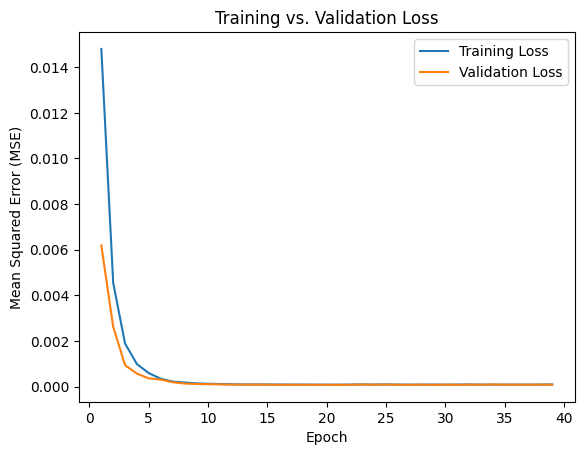

In [ ]:
# @title berkeley_rpt train


EPOCHS = 300

model = tf.keras.models.Model(inputs=inp, outputs=out)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
                 initial_learning_rate=1e-3,
                 decay_steps=len(train_ds)*EPOCHS)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='mse')
history=model.fit(train_ds,
          validation_data=val_ds,
          epochs=EPOCHS,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])
mse = model.evaluate(test_ds, verbose=0)
print("Test RMSE :", np.sqrt(mse))
model.save("berkeley_rpt_model")   # SavedModel → TensorFlow Lite / ONNX ready

import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation loss over epochs.

    Args:
        history: tf.keras.callbacks.History object returned by model.fit()
    """
    # Extract loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.title('Training vs. Validation Loss')
    plt.show()

plot_training_history(history)
#0.0089

In [ ]:

# @title save trained model
from google.colab import drive
drive.mount('/content/drive')

# 2. Choose a folder in your Drive
save_path = '/content/drive/MyDrive/models/berkeley_rpt_model'

# 3. Save your TF model there
model.save(save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:

# @title load trained model
from google.colab import drive
drive.mount('/content/drive')
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/models/berkeley_rpt_model'
)


Mounted at /content/drive


2/2 [==============================] - 0s 94ms/step
Overall test RMSE: 0.0267
Selected test index: 141
Input trajectory (XYZ sequence):
[[ 0.397869 -0.005523  1.3056    0.610548 -0.148948  1.263     0.662101
  -0.218024  1.22751 ]
 [ 0.39384  -0.010272  1.30151   0.608709 -0.136809  1.22789   0.660744
  -0.199318  1.18212 ]
 [ 0.387541 -0.015828  1.29539   0.594396 -0.123394  1.18032   0.64654
  -0.176804  1.1243  ]
 [ 0.379092 -0.019199  1.2875    0.578266 -0.115639  1.1511    0.627475
  -0.163329  1.08774 ]
 [ 0.371333 -0.01887   1.28068   0.565999 -0.106136  1.13205   0.613356
  -0.150503  1.06498 ]
 [ 0.369566 -0.013888  1.2788    0.564389 -0.111018  1.13664   0.610962
  -0.160104  1.07237 ]
 [ 0.374034 -0.009912  1.2824    0.573238 -0.129698  1.16592   0.619263
  -0.186683  1.10809 ]
 [ 0.381306 -0.007052  1.28886   0.57372  -0.161703  1.20725   0.616613
  -0.229126  1.159   ]
 [ 0.388546 -0.007882  1.29592   0.563248 -0.193186  1.24356   0.599855
  -0.270049  1.2053  ]
 [ 0.39575

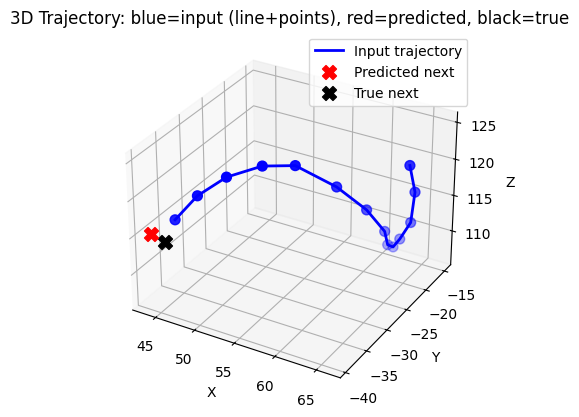

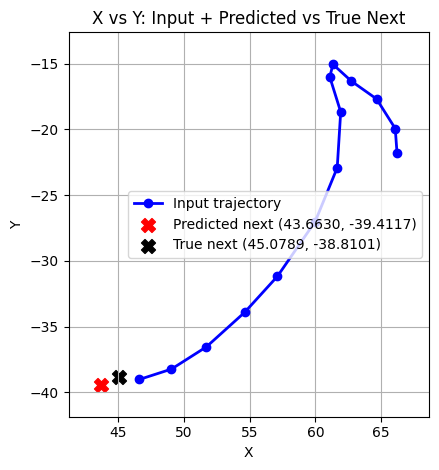

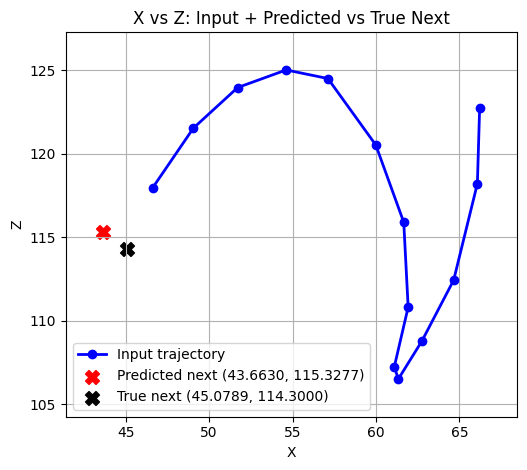

In [26]:
#  @title [undifined tasks(berkeley_rpt)] next step Inference

import numpy as np
import tensorflow as tf


# ---- 1.  Load the SavedModel and the normalisation statistics ----
MODEL_PATH = "berkeley_rpt_model"          # directory created by model.save(...)
NORM_PATH  = "berkeley_rpt_norm.npz"           # you saved this alongside the model

"""
model = tf.keras.models.load_model(
    "berkeley_rpt_model"
)
"""


norm = np.load(NORM_PATH)
MU, SIG = norm["mu"], norm["sig"]

seq_len = traj_len - 1
N = X_test_z.shape[0]
X_test_seq = X_test_z.reshape(N, seq_len, fet_len)

# 2) get predictions
y_pred = model.predict(X_test_seq, batch_size=BATCH, verbose=1)  # shape (N,7)

# 3) compute RMSE
mse    = np.mean((y_pred - y_test)**2, axis=0)
rmse   = np.sqrt(mse)
overall_rmse = np.linalg.norm(rmse)
#print(f"Test RMSE per axis → joint1: {rmse[0]:.4f}, joint2: {rmse[1]:.4f}, joint3: {rmse[2]:.4f}, joint4: {rmse[3]:.4f}, joint5: {rmse[4]:.4f}, joint6: {rmse[5]:.4f}, joint7: {rmse[6]:.4f}")
print(f"Overall test RMSE: {overall_rmse:.4f}")


idx = np.random.randint(0, N)

print(f"Selected test index: {idx}")
# 3) extract input trajectory and true next
input_seq = X_test_seq[idx]   # shape (seq_len, 7)
true_next = y_test[idx]       # shape (7,)

# 4) predict next
pred_next = model.predict(input_seq.reshape(1, seq_len, fet_len), verbose=0)[0]

true_X_test_seq = X_test[idx].reshape(seq_len, fet_len)
# 5) print out the joint pos values
print("Input trajectory (XYZ sequence):")
print(true_X_test_seq)
print(f"True next:    ({true_next}")
print(f"Predicted next: ({pred_next}")


X_test_pos=true_X_test_seq*100.0
pred_next_pos=pred_next*100.0
true_next_pos=true_next*100.0
pos_error = np.linalg.norm(true_next_pos - pred_next_pos)
print(f"Average Euclidean position error: {pos_error/3.0:.4f} cm")

"""
X_test_pos=[]
for i in range(seq_len):
  X_test_pos.append(franka_fk(true_X_test_seq[i]).tolist())
true_next_pos=franka_fk(true_next)*100.0
pred_next_pos=franka_fk(pred_next)*100.0
pos_error = np.linalg.norm(true_next_pos[:3] - pred_next_pos[:3])
print(f"Euclidean position error: {pos_error:.4f} cm")
X_test_pos=np.array(X_test_pos)*100.0
"""
# 6) 3D plot
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

#    blue: input trajectory as line + points
ax.plot(
    X_test_pos[:,6], X_test_pos[:,7], X_test_pos[:,8],
    '-', linewidth=2, label='Input trajectory', color='blue'
)
ax.scatter(
    X_test_pos[:,6], X_test_pos[:,7], X_test_pos[:,8],
    marker='o', s=50, color='blue'
)

#    red: predicted next
ax.scatter(
    pred_next_pos[6], pred_next_pos[7], pred_next_pos[8],
    marker='X', s=100, label='Predicted next', color='red'
)

#    black: true next
ax.scatter(
    true_next_pos[6], true_next_pos[7], true_next_pos[8],
    marker='X', s=100, label='True next', color='black'
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
all_x = np.hstack([
    X_test_pos[:, 6],
    true_next_pos[6],
    pred_next_pos[6]
])
all_y = np.hstack([
    X_test_pos[:, 7],
    true_next_pos[7],
    pred_next_pos[7]
])
all_z = np.hstack([
    X_test_pos[:, 8],
    true_next_pos[8],
    pred_next_pos[8]
])
ax.auto_scale_xyz(all_x, all_y, all_z)
plt.title('3D Trajectory: blue=input (line+points), red=predicted, black=true')
plt.show()


# 2D X vs Y plot for this single-step inference
plt.figure()

# 1) your plotting…
plt.plot(
    X_test_pos[:,6], X_test_pos[:,7],
    '-o', lw=2, ms=6, color='blue', label='Input trajectory'
)
plt.scatter(
    pred_next_pos[6], pred_next_pos[7],
    s=100, marker='X', color='red',
    label=f'Predicted next ({pred_next_pos[6]:.4f}, {pred_next_pos[7]:.4f})'
)
plt.scatter(
    true_next_pos[6], true_next_pos[7],
    s=100, marker='X', color='black',
    label=f'True next ({true_next_pos[6]:.4f}, {true_next_pos[7]:.4f})'
)

# 2) gather all the x/y values into flat arrays
all_x = np.concatenate([
    X_test_pos[:,6],
    [pred_next_pos[6], true_next_pos[6]]
])
all_y = np.concatenate([
    X_test_pos[:,7],
    [pred_next_pos[7], true_next_pos[7]]
])

# 3) compute padding = 10% of the **max** span (or a small absolute minimum)
x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()
span = max(x_max - x_min, y_max - y_min)
pad  = span * 0.10 if span>0 else 0.005

# 4) explicitly set limits
ax = plt.gca()
ax.set_xlim(x_min - pad, x_max + pad)
ax.set_ylim(y_min - pad, y_max + pad)

# 5) now you can safely enforce equal-aspect and finish up
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs Y: Input + Predicted vs True Next')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2D X vs Z plot for this single-step inference
plt.figure()

# 1) your plotting…
plt.plot(
    X_test_pos[:,6], X_test_pos[:,8],
    '-o', lw=2, ms=6, color='blue', label='Input trajectory'
)
plt.scatter(
    pred_next_pos[6], pred_next_pos[8],
    s=100, marker='X', color='red',
    label=f'Predicted next ({pred_next_pos[6]:.4f}, {pred_next_pos[8]:.4f})'
)
plt.scatter(
    true_next_pos[6], true_next_pos[8],
    s=100, marker='X', color='black',
    label=f'True next ({true_next_pos[6]:.4f}, {true_next_pos[8]:.4f})'
)

# 2) gather all the x/y values into flat arrays
all_x = np.concatenate([
    X_test_pos[:,6],
    [pred_next_pos[6], true_next_pos[6]]
])
all_y = np.concatenate([
    X_test_pos[:,8],
    [pred_next_pos[8], true_next_pos[8]]
])

# 3) compute padding = 10% of the **max** span (or a small absolute minimum)
x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()
span = max(x_max - x_min, y_max - y_min)
pad  = span * 0.10 if span>0 else 0.005

# 4) explicitly set limits
ax = plt.gca()
ax.set_xlim(x_min - pad, x_max + pad)
ax.set_ylim(y_min - pad, y_max + pad)

# 5) now you can safely enforce equal-aspect and finish up
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel('X')
plt.ylabel('Z')
plt.title('X vs Z: Input + Predicted vs True Next')
plt.grid(True)
plt.tight_layout()
plt.show()


input trajectory eef positions:[[ 38.2146     -2.4959    129.106      57.249897  -10.9375    113.537
   62.2063    -15.729899  107.246994 ]
 [ 38.158302   -2.5532    129.06       57.113396  -11.2272005 113.521
   62.0519    -16.1051    107.283    ]
 [ 38.2416     -2.5118    129.134      57.3416    -11.6409    114.
   62.308502  -16.659399  107.937004 ]
 [ 38.5203     -2.5351    129.406      57.8344    -13.1991    115.65
   62.7619    -18.6591    109.90501  ]
 [ 38.7368     -2.7115    129.64       57.871998  -15.0269    117.06801
   62.632797  -20.9981    111.703    ]
 [ 38.879      -3.1495001 129.854      57.121098  -18.063099  118.863
   61.390697  -24.775501  113.983    ]
 [ 38.8763     -3.7503    129.958      55.4519    -21.200298  120.122
   59.0007    -28.5396    115.578995 ]
 [ 38.6874     -4.7606    129.987      52.7377    -24.799301  121.21001
   55.304497  -32.7111    116.978004 ]
 [ 37.8689     -6.242     129.596      48.507603  -28.674599  121.877
   49.761097  -37.0303    1

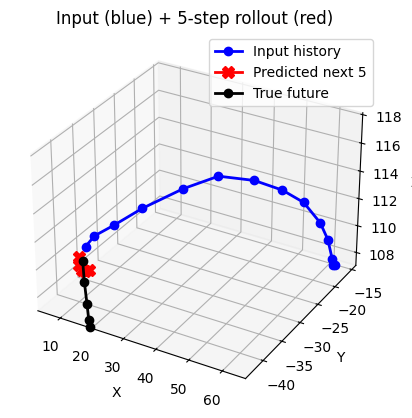

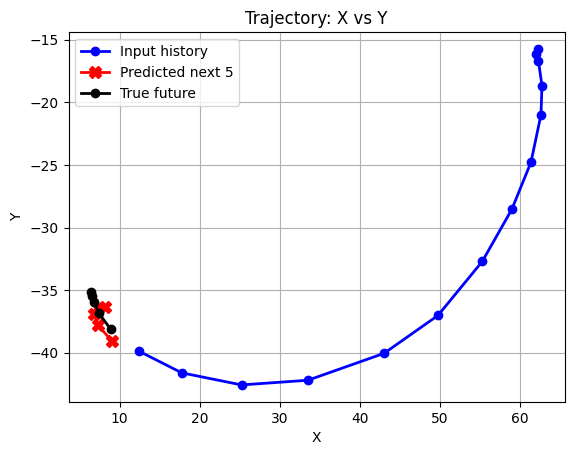

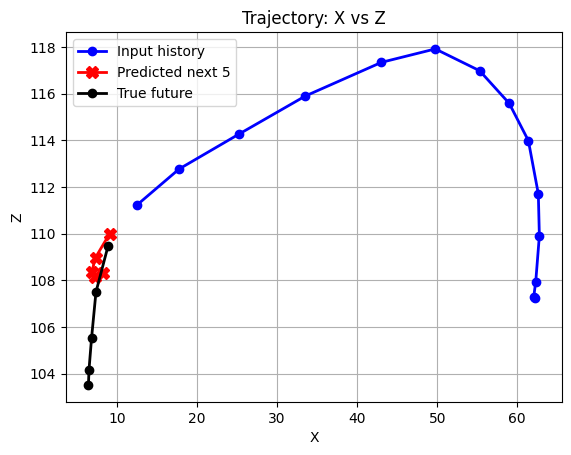

In [24]:
#  @title [undefined tasks(berkeley_rpt)] n step Inference
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# — assume these are already defined above —
#   model, MU, SIG, traj_len
#   predict_next_xyz(seqtraj) → model’s one-step predictor
#   input_seq: your starting history, shape=(traj_len-1,3)
def predict_next_xyz(seqtraj):
  return model.predict(seqtraj.reshape(1, seq_len, fet_len), verbose=0)[0]




# 2) prepare storage
pred_seq = np.zeros((predict_len, fet_len), dtype=np.float32)
current_input = input_seq.copy()   # (traj_len-1,7)

print(f'input trajectory eef positions:{X_test_pos}')

flat = true_X_test_seq.reshape(-1)
key = tuple(flat.tolist())
ground_truth_5 = hist_to_future.get(key, None)

pred_seq_pos=[]
# 3) closed-loop rollout
for i in range(predict_len):
    nxt = predict_next_xyz(current_input)   # (3,)
    pred_seq[i] = nxt.copy()
    pred_seq_pos.append(nxt.tolist())
    #pred_seq_pos.append(franka_fk(nxt).tolist())
    # slide the window: drop oldest, append the new
    for j in range(fet_len): #use the last
      nxt[j]=(nxt[j]-MU[len(MU)-fet_len+j])/SIG[len(MU)-fet_len+j]
    current_input = np.vstack([current_input[1:], nxt])
pred_seq_pos=np.array(pred_seq_pos)*100.0
print(f'predicted eef positions of next {predict_len} steps:{pred_seq_pos}')
true_seq_pos=[]
if ground_truth_5 is not None:
  true_seq_pos = ground_truth_5*100.0
  print(f'ground truth eef positions of next {predict_len} steps:{true_seq_pos}')
  pos_error=0
  for i in range(predict_len):
    pos_error += np.linalg.norm(true_seq_pos[i] - pred_seq_pos[i])
  print(f"Average Euclidean position error per step: {pos_error/3.0/predict_len:.4f} cm")



# 4) plot original + predictions
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')



# original history in blue
ax.plot(
    X_test_pos[:,6], X_test_pos[:,7], X_test_pos[:,8],
    '-o', lw=2, ms=6, color='blue', label='Input history'
)

# future rollout in red
ax.plot(
    pred_seq_pos[:,6], pred_seq_pos[:,7], pred_seq_pos[:,8],
    '-X', lw=2, ms=8, color='red', label=f'Predicted next {predict_len}'
)


# true future path (black dots)
ax.plot(
    true_seq_pos[:,6], true_seq_pos[:,7], true_seq_pos[:,8],
    '-o', lw=2, ms=6, color='black', label='True future'
)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
all_x = np.hstack([X_test_pos[:,6], pred_seq_pos[:,6]])
all_y = np.hstack([X_test_pos[:,7], pred_seq_pos[:,7]])
all_z = np.hstack([X_test_pos[:,8], pred_seq_pos[:,8]])
ax.auto_scale_xyz(all_x, all_y, all_z)
plt.title(f'Input (blue) + {predict_len}-step rollout (red)')
plt.show()


# 2D X vs Y plot of history and rollout
plt.figure()
# history in blue
plt.plot(
    X_test_pos[:,6], X_test_pos[:,7],
    '-o', lw=2, ms=6, color='blue', label='Input history'
)
# rollout in red
plt.plot(
    pred_seq_pos[:,6], pred_seq_pos[:,7],
    '-X', lw=2, ms=8, color='red', label=f'Predicted next {predict_len}'
)

plt.plot(
    true_seq_pos[:,6], true_seq_pos[:,7],
    '-o', lw=2, ms=6, color='black', label='True future'
)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory: X vs Y')
plt.legend()
ax = plt.gca()
ax.relim()
plt.grid(True)
plt.show()

# 2D X vs Z plot of history and rollout
plt.figure()
# history in blue
plt.plot(
    X_test_pos[:,6], X_test_pos[:,8],
    '-o', lw=2, ms=6, color='blue', label='Input history'
)
# rollout in red
plt.plot(
    pred_seq_pos[:,6], pred_seq_pos[:,8],
    '-X', lw=2, ms=8, color='red', label=f'Predicted next {predict_len}'
)

plt.plot(
    true_seq_pos[:,6], true_seq_pos[:,8],
    '-o', lw=2, ms=6, color='black', label='True future'
)

plt.xlabel('X')
plt.ylabel('Z')
plt.title('Trajectory: X vs Z')
plt.legend()
ax = plt.gca()
ax.relim()
plt.grid(True)
plt.show()

Predicted next-step Cartesian positions (metres)
  elbow: [0.27217257 0.01204713 1.3798743 ]
  wrist: [0.4555353 0.3578174 0.7211173]
  palm : [0.51369375 0.37526864 0.8285475 ]


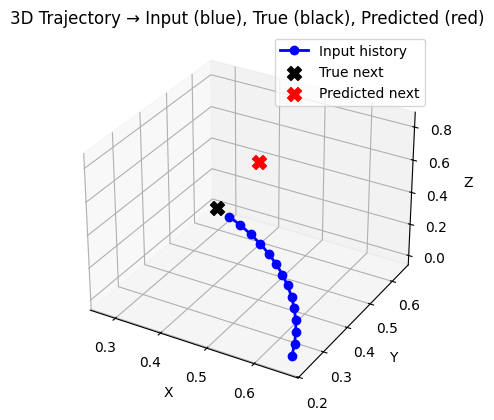

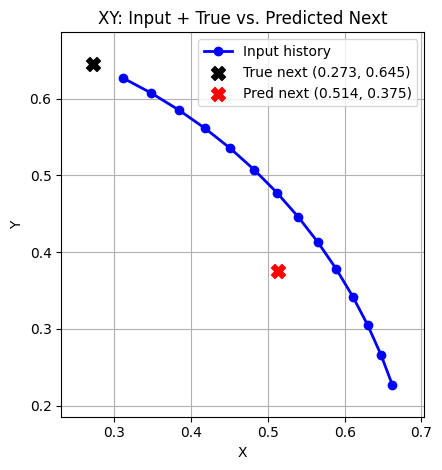

In [30]:
#  @title [undefined tasks] next step Inference using arbitrary trajectory
# ─────────────────────────────────────────────────────────────
#  EXAMPLE ▸ infer the next step for a synthetic concentric-circle trajectory
# ─────────────────────────────────────────────────────────────


import numpy as np

# ------------------------------------------------------------
# Helper: build a planar concentric-circle trajectory
# ------------------------------------------------------------
def make_concentric_traj(seq_len=14,
                         radii=(0.30, 0.50, 0.70),      # elbow, wrist, palm radii [m]
                         phi0=None,                     # starting angle [rad]
                         dphi=0.06):                    # constant angular step [rad]
    """
    Returns an array of shape (seq_len, 9) with columns
      [ex, ey, ez,  wx, wy, wz,  px, py, pz]
    where origin (0,0,0) ≡ shoulder and motion is in the XY-plane (z = 0).
    """
    if phi0 is None:
        phi0 = np.random.uniform(0, 2*np.pi)            # random starting angle
    angles = phi0 + np.arange(seq_len) * dphi

    # elbow coordinates
    ex = radii[0] * np.cos(angles)
    ey = radii[0] * np.sin(angles)
    ez = np.zeros_like(ex)

    # wrist coordinates
    wx = radii[1] * np.cos(angles)
    wy = radii[1] * np.sin(angles)
    wz = np.zeros_like(wx)

    # palm coordinates
    px = radii[2] * np.cos(angles)
    py = radii[2] * np.sin(angles)
    pz = np.zeros_like(px)

    traj = np.vstack([ex, ey, ez,   wx, wy, wz,   px, py, pz]).T  # shape (seq_len, 9)
    return traj


# ------------------------------------------------------------
# 1)  build an arbitrary 14×9 input sequence
# ------------------------------------------------------------
seq_len  = 14
fet_len  = 9
synthetic_traj = make_concentric_traj(seq_len=seq_len)          # (14, 9)

# ------------------------------------------------------------
# 2)  normalise the synthetic data exactly as in training
# ------------------------------------------------------------
synthetic_flat   = synthetic_traj.reshape(-1)            # (126,)

# normalise in the flat space
synthetic_z_flat = (synthetic_flat - MU) / SIG           # (126,)

# reshape into model-input shape
synthetic_z = synthetic_z_flat.reshape(1, seq_len, fet_len)                       # (14, 9)

# ------------------------------------------------------------
# 3)  network inference → denormalise
# ------------------------------------------------------------
pred_z   = model.predict(synthetic_z, verbose=0)[0]             # (9,)
pred_xyz = pred_z                                    # back to metres

# ------------------------------------------------------------
# 4)  unpack and display
# ------------------------------------------------------------
elbow_next = pred_xyz[0:3]
wrist_next = pred_xyz[3:6]
palm_next  = pred_xyz[6:9]

print("Predicted next-step Cartesian positions (metres)")
print(f"  elbow: {elbow_next}")
print(f"  wrist: {wrist_next}")
print(f"  palm : {palm_next}")

# ─────────────────────────────────────────────────────────────
# 5) compute ground-truth next step on the concentric circles
# ─────────────────────────────────────────────────────────────
# recover the initial angle from the first elbow point
phi0 = np.arctan2(synthetic_traj[0,1], synthetic_traj[0,0])
dphi = 0.06
phi_next = phi0 + seq_len * dphi

radii = (0.30, 0.50, 0.70)  # same as make_concentric_traj

true_next_pos = np.array([
    radii[0]*np.cos(phi_next), radii[0]*np.sin(phi_next), 0.0,
    radii[1]*np.cos(phi_next), radii[1]*np.sin(phi_next), 0.0,
    radii[2]*np.cos(phi_next), radii[2]*np.sin(phi_next), 0.0,
])  # shape (9,)

# ─────────────────────────────────────────────────────────────
# 6) unpack positions
# ─────────────────────────────────────────────────────────────
input_pos      = synthetic_traj         # (14, 9)
pred_next_pos  = pred_xyz               # (9,)
true_next_pos  = true_next_pos         # (9,)

# ─────────────────────────────────────────────────────────────
# 7) 3D plot: history (blue), true next (black X), pred next (red X)
# ─────────────────────────────────────────────────────────────
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

# history line + dots
ax.plot(
    input_pos[:,6], input_pos[:,7], input_pos[:,8],
    '-o', lw=2, ms=6, label='Input history', color='blue'
)
# true next
ax.scatter(
    true_next_pos[6], true_next_pos[7], true_next_pos[8],
    marker='X', s=100, label='True next', color='black'
)
# predicted next
ax.scatter(
    pred_next_pos[6], pred_next_pos[7], pred_next_pos[8],
    marker='X', s=100, label='Predicted next', color='red'
)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.legend()
all_x = np.hstack([input_pos[:,6], true_next_pos[6], pred_next_pos[6]])
all_y = np.hstack([input_pos[:,7], true_next_pos[7], pred_next_pos[7]])
all_z = np.hstack([input_pos[:,8], true_next_pos[8], pred_next_pos[8]])
ax.auto_scale_xyz(all_x, all_y, all_z)
plt.title('3D Trajectory → Input (blue), True (black), Predicted (red)')
plt.show()

# ─────────────────────────────────────────────────────────────
# 8) 2D XY plot
# ─────────────────────────────────────────────────────────────
plt.figure()
plt.plot(
    input_pos[:,6], input_pos[:,7],
    '-o', lw=2, ms=6, color='blue', label='Input history'
)
plt.scatter(
    true_next_pos[6], true_next_pos[7],
    s=100, marker='X', color='black',
    label=f'True next ({true_next_pos[6]:.3f}, {true_next_pos[7]:.3f})'
)
plt.scatter(
    pred_next_pos[6], pred_next_pos[7],
    s=100, marker='X', color='red',
    label=f'Pred next ({pred_next_pos[6]:.3f}, {pred_next_pos[7]:.3f})'
)

# pad & equalize
x_all = np.concatenate([input_pos[:,6], [true_next_pos[6], pred_next_pos[6]]])
y_all = np.concatenate([input_pos[:,7], [true_next_pos[7], pred_next_pos[7]]])
xmin, xmax = x_all.min(), x_all.max()
ymin, ymax = y_all.min(), y_all.max()
span = max(xmax-xmin, ymax-ymin)
pad = span * 0.1
ax2 = plt.gca()
ax2.set_xlim(xmin-pad, xmax+pad)
ax2.set_ylim(ymin-pad, ymax+pad)
ax2.set_aspect('equal', 'box')

plt.xlabel('X'); plt.ylabel('Y')
plt.legend()
plt.title('XY: Input + True vs. Predicted Next')
plt.grid(True)
plt.tight_layout()
plt.show()